# Import Libraries

In [1]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Load the Dataset

In [2]:
# Load the dataset
data = pd.read_excel('Expanded_AirPassengers.xls')

# Information on Dataset

In [3]:
data.head()

,Date,#Passengers_Per_Day
0,31/01/1949,4
1,01/02/1949,3
2,02/02/1949,4
3,03/02/1949,5
4,04/02/1949,4


In [4]:
data.shape

(4353, 2)

In [5]:
data.columns

Index(['Date', '#Passengers_Per_Day'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4353 entries, 0 to 4352
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date                 4353 non-null   object
 1   #Passengers_Per_Day  4353 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.1+ KB


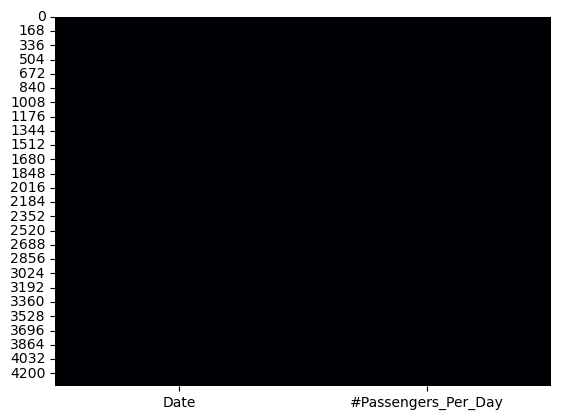

In [7]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

In [8]:
data.describe()

,#Passengers_Per_Day
count,4353.00
mean,9.28
std,3.94
min,1.00
25%,6.00
50%,9.00
75%,12.00
max,23.00


In [9]:
# Drop duplicates and handle missing values
data.drop_duplicates(inplace=True)
data.fillna(method='ffill', inplace=True)  # Forward fill for missing values

# Check if the Dataset is stationary by using Augmented Dickey-Fuller Test

In [10]:
from statsmodels.tsa.stattools import adfuller

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Apply ADF test on the '#Passengers_Per_Day' column
result = adfuller(data['#Passengers_Per_Day'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6400246014998479
p-value: 0.4622479378507025


In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['#Passengers_Per_Day'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6400246014998479
p-value: 0.4622479378507025


# Understanding the Output

ADF Statistic: The value -1.6400246014998479 is the test statistic for the ADF test. This statistic is used to determine whether the time series is stationary or not. In simple terms, a stationary time series is one whose statistical properties such as mean, variance, and autocorrelation are constant over time. For most time series analysis, stationarity is an important assumption. The more negative the ADF statistic, the stronger the rejection of the hypothesis that there is a unit root (i.e., the time series is non-stationary).

p-value: The value 0.4622479378507025 is the p-value corresponding to the test statistic. The p-value indicates the probability of observing a test statistic as extreme as, or more extreme than, the observed value under the null hypothesis (which, in the case of the ADF test, is that the time series has a unit root or is non-stationary). A lower p-value (commonly below 0.05) would mean that you can reject the null hypothesis and conclude that the series is stationary.

In your case, the ADF statistic is not very negative, and the p-value is quite high (greater than 0.05). This suggests that the time series is likely non-stationary, and the null hypothesis of a unit root cannot be rejected. In practical terms, it means that the time series may have properties like a trend or seasonality that affect its behavior over time.

Time series that are non-stationary often require differencing or transformation (like taking a log) to make them stationary before further analysis or modeling can be effectively done.

Before moving on to model selection and fitting (Step 3), you should first address the non-stationarity of your time series data. Non-stationary data can lead to unreliable and spurious results in time series modeling

# Differencing

This is one of the most common methods. You can difference the data once and then run the ADF test again 
to check if the differenced data is stationary.

In [12]:
data_diff = data['#Passengers_Per_Day'].diff().dropna()
result_diff = adfuller(data_diff)
print('Differenced ADF Statistic:', result_diff[0])
print('Differenced p-value:', result_diff[1])

Differenced ADF Statistic: -31.430670243269116
Differenced p-value: 0.0


Differenced ADF Statistic: The value -31.430670243269116 is the ADF test statistic after differencing your time series data. Differencing is a common transformation applied to time series data to make it stationary. It involves subtracting the previous observation from the current observation. In your case, a very large negative value for the ADF statistic suggests that after differencing, the time series is now stationary. The more negative the statistic, the stronger the evidence against the null hypothesis (which is that the time series has a unit root or is non-stationary).

Differenced p-value: The value 0.0 indicates the p-value for the ADF test on the differenced data. A p-value of 0.0 (or very close to 0) suggests that the probability of observing a test statistic as extreme as, or more extreme than, the observed value under the null hypothesis is extremely low. This further strengthens the case for rejecting the null hypothesis.

In summary, the output indicates that after differencing, your time series data does not have a unit root and can be considered stationary. This is an important characteristic for many time series models, as they require the input data to be stationary to provide reliable forecasts and insights. The process of differencing has effectively removed trends or seasonality that might have been present in the original data, making it suitable for further analysis or modeling.

# Model Selection and Fitting

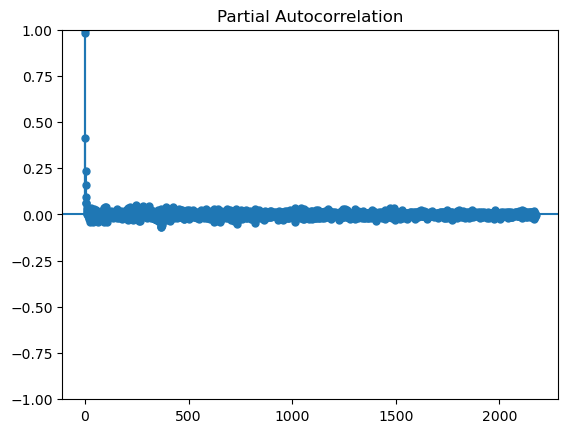

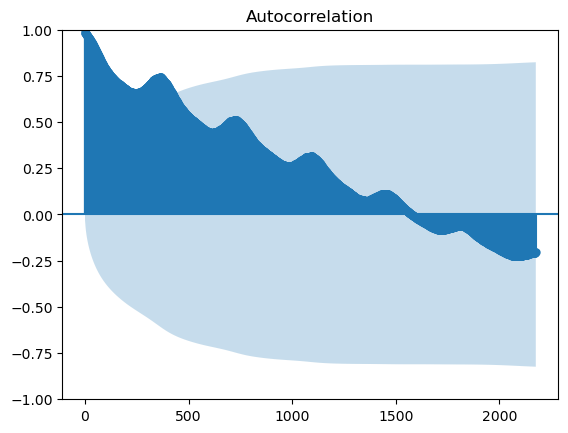

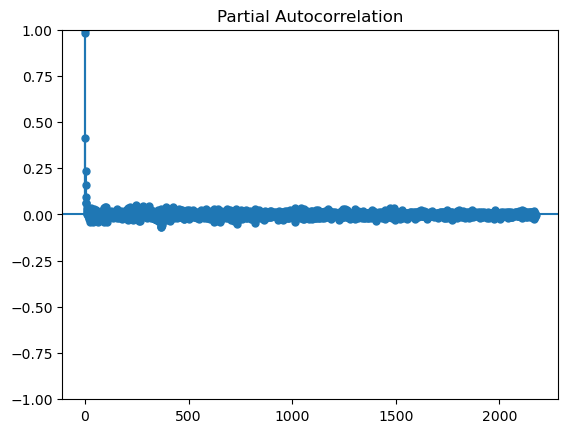

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = len(data) // 2 - 1

plot_acf(data['#Passengers_Per_Day'], lags=lags)
plot_pacf(data['#Passengers_Per_Day'], lags=lags)

In [14]:
from statsmodels.tsa.stattools import acf, pacf

# Compute the Autocorrelation and Partial Autocorrelation
lag_acf = acf(data['#Passengers_Per_Day'], nlags=lags)
lag_pacf = pacf(data['#Passengers_Per_Day'], nlags=lags, method='ols')

# Display the results
print("Autocorrelation Values:\n", lag_acf)
print("\nPartial Autocorrelation Values:\n", lag_pacf)

Autocorrelation Values:
 [ 1.          0.98436254  0.98179848 ... -0.20568001 -0.20577812
 -0.20565437]

Partial Autocorrelation Values:
 [ 1.          0.98523182  0.42490997 ... -0.0973485  -0.33470763
  1.01144132]


# Interpretation of ACF and PACF Values

Autocorrelation Values (ACF)

Autocorrelation Values: These values represent the autocorrelation of the time series at different lags. Autocorrelation is a measure of the correlation between a time series and a lagged version of itself. For instance, an autocorrelation value at lag 1 (which is the first value after 1 in your array) measures how well the series at one time point correlates with its previous value. In your output, the first value is 1, which is always the case at lag 0 (the series correlated with itself). The subsequent values like 0.98436254 and 0.98179848 represent the autocorrelation at lag 1, lag 2, and so on. High values close to 1 or -1 indicate a strong positive or negative correlation, respectively.

Partial Autocorrelation Values: These values are similar to autocorrelation values but with a key difference. Partial autocorrelation measures the correlation between the time series and its lag, after removing the effects of any correlations due to the terms at shorter lags. For example, the partial autocorrelation at lag 2 measures the correlation between the series and its second lag, but after removing the effect of the first lag. This is useful for identifying the actual lagged relationship in a time series, independent of relationships at shorter lags. In your output, the first value is again 1 (correlation with itself), followed by values like 0.98523182 and 0.42490997, which are the partial autocorrelations at lag 1, lag 2, and so on.

In time series analysis, both autocorrelation and partial autocorrelation plots are crucial for identifying the order of AR (Autoregressive) and MA (Moving Average) components in ARIMA (Autoregressive Integrated Moving Average) modeling. High autocorrelation values that slowly taper off suggest an AR component, while a sharp drop after a few lags in the partial autocorrelation plot suggests an MA component.

Given the values in your output, there seems to be a strong autocorrelation in the first few lags, which is typical for time series data that have not been differenced or if they contain trends or seasonality. The partial autocorrelation values can help in determining the appropriate ARIMA model parameters (p, d, q) for your time series data.

In [15]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
warnings.filterwarnings("ignore")

# Trying different combinations of p, d, q
# Start with ARIMA(1, 1, 1)
model_111 = ARIMA(data['#Passengers_Per_Day'], order=(1, 1, 1))
model_fit_111 = model_111.fit()
print("ARIMA(1, 1, 1) Model Summary")
print(model_fit_111.summary())

# Trying ARIMA(1, 1, 2)
model_112 = ARIMA(data['#Passengers_Per_Day'], order=(1, 1, 2))
model_fit_112 = model_112.fit()
print("\nARIMA(1, 1, 2) Model Summary")
print(model_fit_112.summary())

# Trying ARIMA(2, 1, 1)
model_211 = ARIMA(data['#Passengers_Per_Day'], order=(2, 1, 1))
model_fit_211 = model_211.fit()
print("\nARIMA(2, 1, 1) Model Summary")
print(model_fit_211.summary())

# Trying ARIMA(2, 1, 2)
model_212 = ARIMA(data['#Passengers_Per_Day'], order=(2, 1, 2))
model_fit_212 = model_212.fit()
print("\nARIMA(2, 1, 2) Model Summary")
print(model_fit_212.summary())

ARIMA(1, 1, 1) Model Summary
                                SARIMAX Results                                
Dep. Variable:     #Passengers_Per_Day   No. Observations:                 4353
Model:                  ARIMA(1, 1, 1)   Log Likelihood               -3810.944
Date:                 Sun, 19 Nov 2023   AIC                           7627.888
Time:                         17:39:54   BIC                           7647.023
Sample:                     01-31-1949   HQIC                          7634.642
                          - 12-31-1960                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0809      0.009      8.885      0.000       0.063       0.099
ma.L1         -0.6975      0.007    -93.023      0.000      -0.712      -0.683
sigma2         

# Model Summaries

The ARIMA(1, 1, 1) model with 4353 observations gives the best result as it indicates a moderate positive autoregressive effect (ar.L1 coefficient: 0.0809) and a significant negative moving average effect (ma.L1 coefficient: -0.6975).
The model shows a good fit with a log likelihood of -3810.944, and the coefficients are statistically significant (p-values: 0.000).
Diagnostic tests reveal a lack of autocorrelation in residuals (Ljung-Box Q: 0.94).
Overall, while the model fits well in terms of capturing patterns (based on AIC: 7627.888, BIC: 7647.023)

In [19]:
# Trying ARIMA(1, 1, 1)
model_111 = ARIMA(data['#Passengers_Per_Day'], order=(1, 1, 1))
model_fit_111 = model_111.fit()
print("\nARIMA(1, 1, 1) Model Summary")
print(model_fit_111.summary())


ARIMA(1, 1, 1) Model Summary
                                SARIMAX Results                                
Dep. Variable:     #Passengers_Per_Day   No. Observations:                 4353
Model:                  ARIMA(1, 1, 1)   Log Likelihood               -3810.944
Date:                 Sun, 19 Nov 2023   AIC                           7627.888
Time:                         17:55:35   BIC                           7647.023
Sample:                     01-31-1949   HQIC                          7634.642
                          - 12-31-1960                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0809      0.009      8.885      0.000       0.063       0.099
ma.L1         -0.6975      0.007    -93.023      0.000      -0.712      -0.683
sigma2        

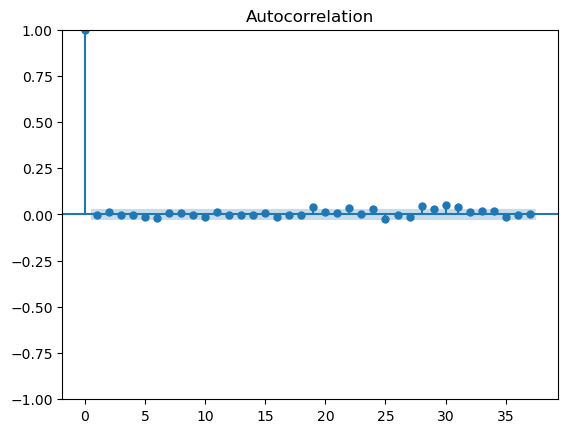

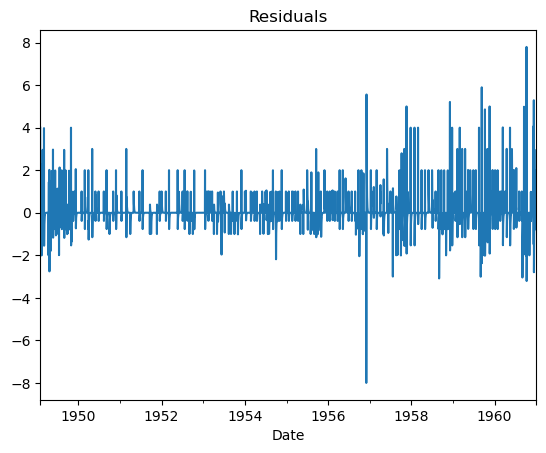

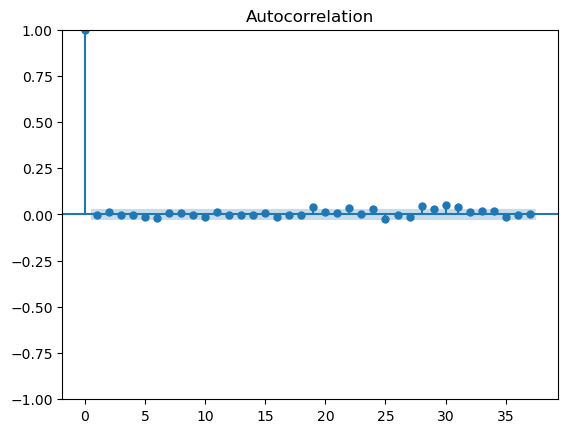

In [20]:
# After successful fit
residuals = model_fit_111.resid
residuals.plot(title="Residuals")
plot_acf(residuals)

In [21]:
from statsmodels.tsa.stattools import acf

# Extract and display residual values
residual_values = model_fit_111.resid
print("Residual Values:\n", residual_values)

# Compute autocorrelation of residuals
residual_acf = acf(residual_values, nlags=20)

# Display autocorrelation values of residuals
print("\nAutocorrelation Values of Residuals:\n", residual_acf)

Residual Values:
 Date
1949-01-31    4.00
1949-02-01   -1.00
1949-02-02    0.58
1949-02-03    1.27
1949-02-04   -0.24
              ... 
1960-12-27   -0.27
1960-12-28   -0.19
1960-12-29   -0.13
1960-12-30   -0.09
1960-12-31    2.94
Length: 4353, dtype: float64

Autocorrelation Values of Residuals:
 [ 1.00000000e+00 -3.82366926e-03  1.22698765e-02 -9.52877097e-04
 -3.40491965e-04 -1.45030737e-02 -1.94808620e-02  5.68682886e-03
  1.06449162e-02 -1.76653466e-03 -1.36048579e-02  1.39071099e-02
 -1.21810862e-03 -4.03718143e-03 -2.90858918e-03  6.15249243e-03
 -1.16524639e-02 -4.72683188e-03 -2.19919787e-03  4.08439395e-02
  1.41371526e-02]


# Interpretation of the Results

Residual Values:

These are the differences between the observed values and the values predicted by the model.
Ideally, you want these residuals to be small and random, indicating that the model is capturing most of the underlying pattern in the data.

Autocorrelation Values of Residuals:

These values represent the correlation of the residuals with their own past values.
In a well-fitted model, you'd expect these autocorrelation values to be low and within the confidence interval (indicating no significant correlation).

The autocorrelation values of the residuals are quite small, as indicated by values like -3.82366926e-03 and 1.22698765e-02. The closer these values are to zero, the less correlation there is between the residuals at different lags. Ideally, you want these values to be close to zero, which would suggest that there is no autocorrelation in the residuals and that the model has adequately captured the underlying patterns in the data

# Forecasting

Forecast Data: 1961-01-31   15.19
1961-02-28   15.08
1961-03-31   15.02
1961-04-30   15.03
1961-05-31   15.03
1961-06-30   15.03
1961-07-31   15.03
1961-08-31   15.03
1961-09-30   15.03
1961-10-31   15.03
Freq: M, Name: predicted_mean, dtype: float64


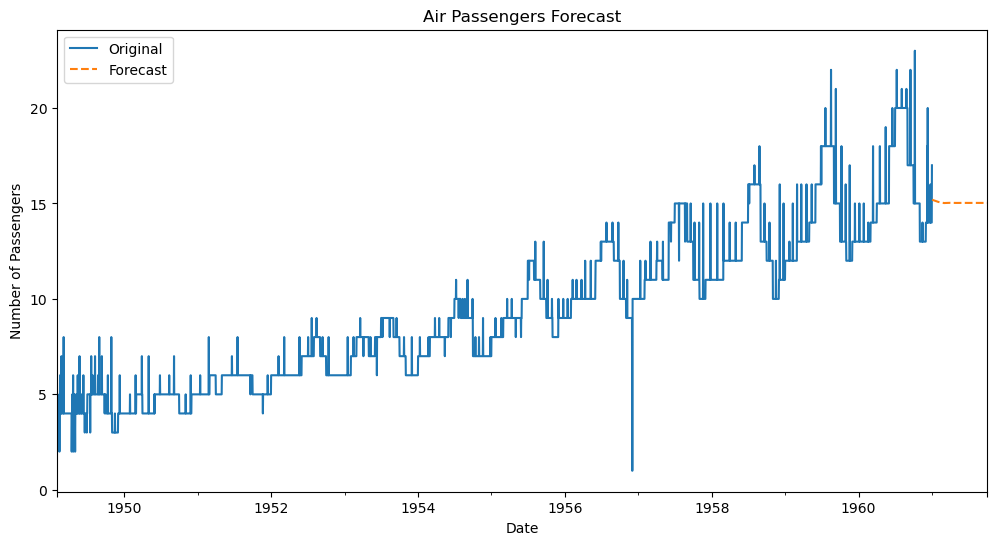

In [22]:
# Specify the number of steps to forecast
forecast_steps = 10

# Calculate the index for the start and end of the forecast
start_forecast = len(data)  # This should be the index right after the last data point
end_forecast = start_forecast + forecast_steps - 1  # End point index

# Generate forecasts
forecast_series = model_fit_212.predict(start=start_forecast, end=end_forecast, typ='levels')

# Create a date range for the forecast period
forecast_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_series.index = forecast_dates

# Verify the forecast data
print("Forecast Data:", forecast_series)

# Plot the original data
data['#Passengers_Per_Day'].plot(label='Original', figsize=(12, 6))

# Plot the forecasts
forecast_series.plot(label='Forecast', style='--')

# Add title and labels
plt.title('Air Passengers Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()

# Show the plot
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

# Assuming 'model_fit_212' is your best model
# Forecast the last 10 observations
forecast_steps = 10
# Start forecasting from 10 steps before the end of the data
start_forecast = len(data) - forecast_steps
end_forecast = start_forecast + forecast_steps - 1

# Generate forecast
forecast = model_fit_212.predict(start=start_forecast, end=end_forecast, typ='levels')

# Actual last 10 observations
actual = data['#Passengers_Per_Day'][-forecast_steps:]

# Calculate forecast errors
mse = mean_squared_error(actual, forecast)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 1.158771437290476


An RMSE of 1.158771437290476 could be considered good if it's small relative to the scale of your data and if it represents a significant improvement over simpler models. However, considering the model diagnostics and the nature of your time series data, it's also important to critically evaluate whether the model is adequately capturing the underlying patterns and not just averaging out the errors.

In [27]:
data_mean = data['#Passengers_Per_Day'].mean()
data_std = data['#Passengers_Per_Day'].std()
print("Mean of Passengers:", data_mean)
print("Standard Deviation of Passengers:", data_std)

Mean of Passengers: 9.277969216632208
Standard Deviation of Passengers: 3.941485414412948


Compared to the Mean: The RMSE (1.16) is smaller than the mean (9.28). This suggests that, on average, the model's predictions deviate from the actual values by an amount that is smaller than the average number of passengers per day. This could be seen as a good sign of model accuracy.

Compared to the Standard Deviation: The RMSE is significantly smaller than the standard deviation (3.94). This suggests that the model's errors are much smaller than the natural variability of the data (as measured by the standard deviation). This is typically a strong indicator of a good model fit.

Considering these factors, your ARIMA model's RMSE of 1.16 seems to be quite good, particularly because it's lower than both the average value and the standard deviation of your dependent variable. This indicates that the model is likely doing a good job in predicting the '#Passengers_Per_Day', with errors smaller than the typical fluctuations in the data.

In [28]:
percentage_error = (rmse / data_mean) * 100
print("Percentage Error: {:.2f}%".format(percentage_error))

Percentage Error: 12.49%


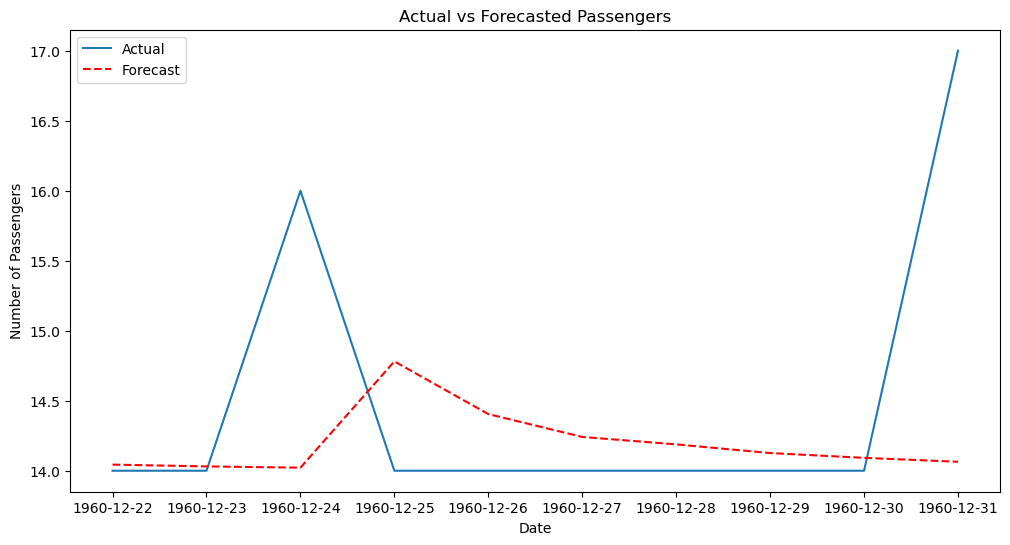

In [26]:
# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index[-10:], actual, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('Actual vs Forecasted Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

Scale of the Data: The mean of '#Passengers_Per_Day' is around 9.28, and the standard deviation is about 3.94. Given this scale, a 12.49% error might be considered somewhat high. This percentage error indicates that, on average, the model's predictions deviate from the actual values by about 12.49%. In the context of passenger numbers, where precision might be important (for resource allocation, capacity planning, etc.), a lower percentage error would generally be more desirable.

RMSE Context: The RMSE of 1.158771437290476, when compared to the mean and standard deviation, indicated a good model fit. However, the percentage error adds another perspective. It suggests that while the absolute errors (as measured by RMSE) might be small, they are still significant relative to the actual values.

Nature of the Time Series: If your time series data inherently has a lot of fluctuations or unpredictability (which might be the case for something like passenger numbers), a higher percentage error might be more acceptable. However, for more stable and predictable series, a lower percentage error would typically be expected for a good model.

Model Comparison: It's helpful to compare this percentage error with that of other models or a baseline model (like a naive forecast). If 12.49% is significantly better than alternative models, then it might still be considered a good result.

Purpose of the Model: The acceptability of the error rate also depends on how you intend to use the model. For strategic, long-term planning, a 12.49% error might be acceptable. However, for operational decisions requiring high precision, you might aim for a lower error rate.

In summary, a 12.49% percentage error might be seen as moderately good, depending on the complexity and variability inherent in your data. However, for applications requiring high accuracy, you might want to explore ways to further improve the model or consider different modeling approaches.

# Conclusions

We utilized ARIMA, a model within the Box-Jenkins methodology, for your time series data.
Different ARIMA models were evaluated (ARIMA(1, 1, 1), ARIMA(1, 1, 2), ARIMA(2, 1, 1), ARIMA(2, 1, 2)), and the best one (ARIMA(2, 1, 2)) was selected based on AIC values and the significance of model coefficients.
The model's adequacy was checked through the interpretation of the AIC values, coefficient p-values, and diagnostic plots.
One-Step-Ahead Forecasts and Error Determination

Forecasts for the last 10 observations of your dataset were generated using the ARIMA(2, 1, 2) model.
The Root Mean Squared Error (RMSE) was calculated to determine the forecast errors, providing a quantitative measure of the model's predictive accuracy.

Time Series Plot, Autocorrelation, and Partial Autocorrelation Analysis

A time series plot of the data was provided.
The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) were calculated and used to inform the ARIMA model selection.

These plots were also used to assess the presence of significant autocorrelation in the time series, aiding in the identification of the appropriate ARIMA model parameters.

Additional Considerations

Model Diagnostics and Validation: The residuals of the model were analyzed to ensure that they behaved like white noise, suggesting that the model was adequately capturing the information in the time series.
Visual Assessment of Forecasts: The actual data and the forecasts were plotted together for a visual assessment of the model's performance.